In [32]:
import torch 
from PIL import Image

from lavis.models import load_model_and_preprocess

/home/ommos92/miniconda3/envs/lavis_dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [132]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

class WGVDataset(Dataset):
    def __init__(self, image_folder, csv_file, transform=None):
        
        self.image_folder = image_folder
        self.csv_file = csv_file
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the city name from the CSV file
        city = self.data.iloc[idx, 0]  # assuming the city name is in the first column

        # Expand the tilde ~ in the image folder path to the home directory
        image_folder = os.path.expanduser(self.image_folder)

        # Find the image file in the image folder that contains the city name
        for filename in os.listdir(image_folder):
            if city in filename:
                img_path = os.path.join(image_folder, filename)
                break
        else:
            raise FileNotFoundError(f"No image file containing '{city}' found in the image folder")

        # Open the image file
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        city = self.data.iloc[idx, 0]
        state = self.data.iloc[idx, 1]
        country = self.data.iloc[idx, 2]
        continent = self.data.iloc[idx, 3]

        return image, city, state, country, continent

# Define the paths to the image folder and CSV file
image_folder = "~/.cache/lavis/WGV/val"
csv_file = "~/.cache/lavis/WGV/labels_list.csv"

# Define any additional transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #type casting the tensor to float16
    transforms.Lambda(lambda x: x.type(torch.float16)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [133]:

# Create an instance of the LocationDataset
dataset = WGVDataset(image_folder, csv_file, transform)

# Create a DataLoader to load the data in batches
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


City: Banglore
State: Karnataka
Country: India
Continent: Asia


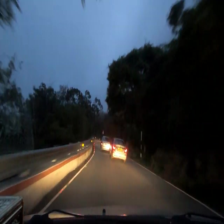

In [134]:
import random

# Load a sample image
image, city, state, country, continent = dataset[random.randint(0, len(dataset) - 1)]

# Show the image state, country, and continent
print("City:", city)
print("State:", state)
print("Country:", country)
print("Continent:", continent)

# Show the image
# Convert the Tensor object to a PIL.Image object
image_pil = transforms.ToPILImage()(image)

# Show the image
image_pil.show()


## Load the BLIP-2 VQA Model


In [97]:
# setup device to use
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [62]:
#Load the model for VQA
model, vis_processors, txt_processors = load_model_and_preprocess(
    name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
)

print(vis_processors.keys())
print(txt_processors.keys())


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.13s/it]


dict_keys(['train', 'eval'])
dict_keys(['train', 'eval'])


Model Answer: ['miami']
GT City: Miami
GT State: Florida
GT Country: United_States
GT Continent: North_America


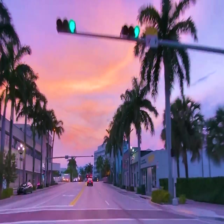

In [422]:
#VQA Open Ended

# Load a sample image
image, city, state, country, continent = dataset[random.randint(0, len(dataset) - 1)]
#Prepare the image using vis processor, needs to be in PIL Image type
image_pil = transforms.ToPILImage()(image)
image = vis_processors["eval"](image_pil).unsqueeze(0).to(device)

# ask a random question.
question = "Question: Which city is this photo taken? Answer:"


#Generate the text using the image and prompt
result = model.predict_answers({"image": image, "text_input": question})
print("Model Answer:", result)
# Ground Truth
print("GT City:", city)
print("GT State:", state)
print("GT Country:", country)
print("GT Continent:", continent)

# Show the image
image_pil.show()

Model Answer: ['Europe']
GT City: Boston
GT State: Massachusetts
GT Country: United_States
GT Continent: North_America


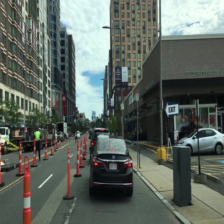

In [469]:
#VQA Close Ended
# Load a sample image
image, city, state, country, continent = dataset[random.randint(0, len(dataset) - 1)]
#Prepare the image using vis processor, needs to be in PIL Image type
image_pil = transforms.ToPILImage()(image)
image = vis_processors["eval"](image_pil).unsqueeze(0).to(device)

answer_list = ['North America', 'South America', 'Europe', 'Asia', 'Other']
question = "Question: Which continent is this photo taken? Answer:"

#Generate the text using the image and prompt
result = model.predict_answers({"image": image, "text_input": question}, answer_list=answer_list)


print("Model Answer:", result)
# Ground Truth
print("GT City:", city)
print("GT State:", state)
print("GT Country:", country)
print("GT Continent:", continent)

# Show the image
image_pil.show()

In [482]:
#Retrieval Task
#Load the model for Retrieval
model, vis_processors, txt_processors = load_model_and_preprocess(
    name="blip2", model_type="pretrain", is_eval=True, device=device
)

print(vis_processors.keys())
print(txt_processors.keys())

dict_keys(['train', 'eval'])
dict_keys(['train', 'eval'])


In [483]:
templates = [
    'a photo i took in {}.',
    'a photo i took while visiting {}.',
    'a photo from my home country of {}.',
    'a photo from my visit to {}.',
    'a photo showing the country of {}.',
]


In [497]:
from torch.cuda.amp import autocast
#VQA Close Ended
# Load a sample image
image, city, state, country, continent = dataset[random.randint(0, len(dataset) - 1)]

location = [city,state,country,continent]

#Prepare the image using vis processor, needs to be in PIL Image type
image_pil = transforms.ToPILImage()(image)
image = vis_processors["eval"](image_pil).unsqueeze(0).to(device)
image = image.to(torch.float16)


for text in templates:
    
    for loc in location:
        txt = text.format(loc)
        print(txt)
        txt = txt_processors["eval"](txt)            
        itm_output = model({"image": image, "text_input": txt})
        
        itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
    print(f'The image and text are matched with a probability of {itm_scores[:, 1].item():.3%}')

a photo i took in Kanpur.


RuntimeError: self and mat2 must have the same dtype, but got Float and Half